In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)

# Read Data

## Amazon Fashion

### With styles, par_col column, colors, cleaned

In [17]:
df = pd.read_pickle('Data/df_styles_and_cleaned_colors')
df.head()

,rating,verified,reviewTime,user,item,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,Style:,Size Name:,Metal Type:,Item Display Length:,Size:,Color:,Team Name:,Length:,Material:,Item Package Quantity:,Scent Name:,Gem Type:,Shape:,Format:,Style Name:,Package Quantity:,par_col,Color2:,par_col2
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


### Without styles

In [ ]:
df = pd.read_csv('Data/amazon_fashion.csv', names=['item','user','rating'])
df.head()

In [ ]:
df['rating'] = df['rating'].astype(int)

## MovieLens

In [63]:
df = pd.read_csv('Data/movie_lens_ratings_small.csv').drop(columns=['timestamp'])
df.head()
df.columns = ['user', 'item', 'rating']
print('rating interval:', df.rating.unique().min(), ',', df.rating.unique().max())
df.head()

rating interval: 0.5 , 5.0


,user,item,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


# Data Exploration

First filtering active users and rated items with x or more ratings:

In [3]:
item_thres = 3
user_thres = 3

In [4]:
df['#ratings'] = df.groupby('item')['item'].transform('count')
df = df[df['#ratings'] >= item_thres].drop(columns=['#ratings'])

df['#ratings'] = df.groupby('user')['user'].transform('count')
df = df[df['#ratings'] >= user_thres].drop(columns=['#ratings'])

In [5]:
norpu = df.groupby('user')['rating'].count().mean()
norpi = df.groupby('item')['rating'].count().mean()
total_users = df.user.unique().size
total_items = df.item.unique().size

## Sub Sample

In [37]:
df = df.sample(frac=0.5, random_state=1234)

rows  897411 
#ratings 897411 
#ratings/user 3.77 
#ratings/item 3.56 
average rating 3.91 
#users  749233 
#items  186189


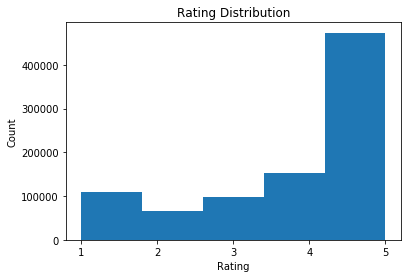

In [18]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size)
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1,6))
plt.show()

## Style analysis

In [19]:
keys = ['Style:',
 'Size Name:',
 'Metal Type:',
 'Item Display Length:',
 'Size:',
 'Color:',
 'Team Name:',
 'Length:',
 'Material:',
 'Item Package Quantity:',
 'Scent Name:',
 'Gem Type:',
 'Shape:',
 'Format:',
 'Style Name:',
 'Package Quantity:']

In [20]:
style_perc_present = []
for style in keys:
    style_perc_present.append(1 - df[style].isnull().sum() / len(df))

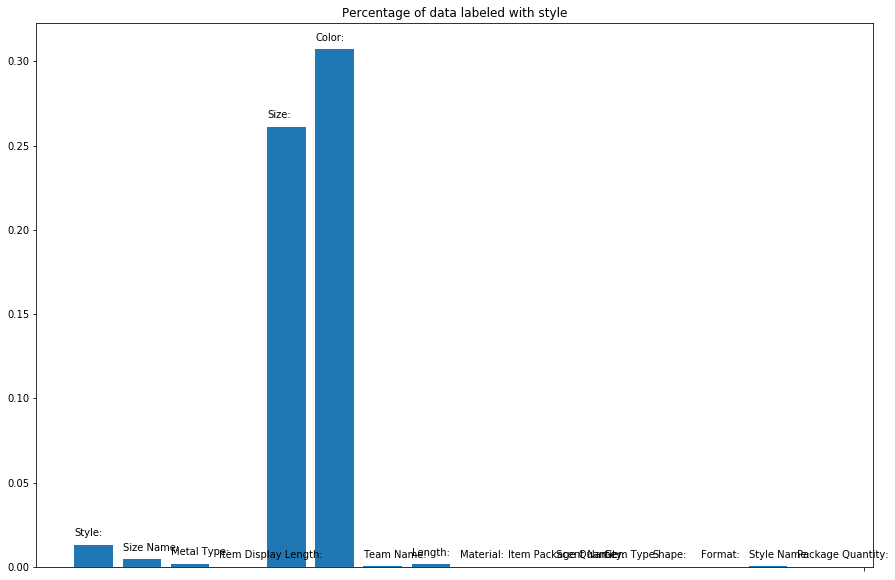

In [21]:
plt.rcParams['figure.figsize'] = [15,10]
bars = plt.bar(keys, style_perc_present)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.005, keys[i])
plt.title('Percentage of data labeled with style')
plt.xticks('')
plt.show()

### Color Focus

#### Oiriginal Colors

In [22]:
color_labels = df.groupby('Color:')['rating'].count().sort_values(ascending=False).index
color_perc_present = list(list(df.groupby('Color:')['rating'].count().sort_values(ascending=False)) / (len(df) - df['Color:'].isnull().sum()))

total_perc = 0
labels = []
for i, perc in enumerate(color_perc_present):
    total_perc += perc
    labels.append(color_labels[i])
    if total_perc > 0.20:
        break
        
print('20% of cum_dist labels: ', labels)

20% of cum_dist labels:  [' Black', ' White']


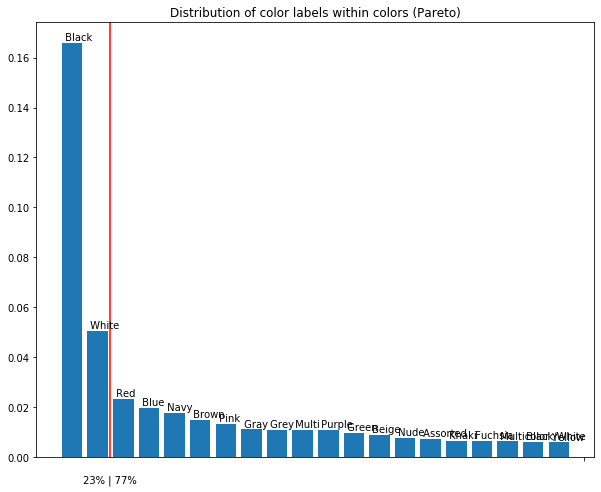

Note: 11046 color labels in total


In [23]:
plt.rcParams['figure.figsize'] = [10,8]
bars = plt.bar(color_labels[:20], color_perc_present[:20])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.001, color_labels[i])
plt.title('Distribution of color labels within colors (Pareto)')
plt.xticks('')
plt.text(0.43, -0.01, '23% | 77%')
plt.axvline(x=1.5, color='red')
plt.show()
print('Note: 11046 color labels in total')

#### Cleaned colors

In [24]:
color_labels = df.groupby('Color2:')['rating'].count().sort_values(ascending=False).index
color_perc_present = list(list(df.groupby('Color2:')['rating'].count().sort_values(ascending=False)) / (len(df) - df['Color:'].isnull().sum()))

total_perc = 0
labels = []
for i, perc in enumerate(color_perc_present):
    total_perc += perc
    labels.append(color_labels[i])
    if total_perc > 0.20:
        break
        
print('20% of cum_dist labels: ', labels)

20% of cum_dist labels:  [' Black']


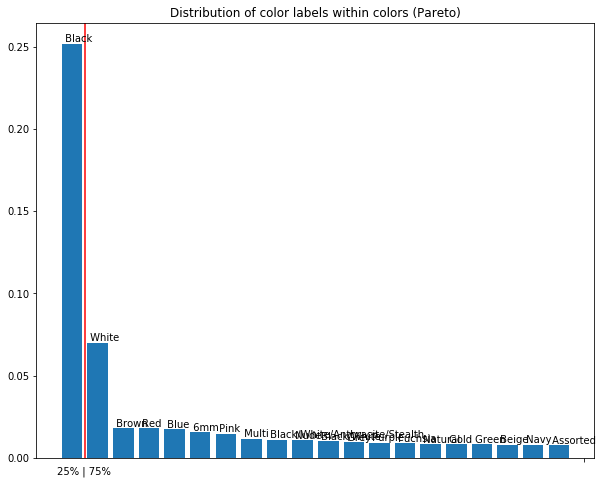

Note: 11046 color labels in total


In [25]:
plt.rcParams['figure.figsize'] = [10,8]
bars = plt.bar(color_labels[:20], color_perc_present[:20])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.001, color_labels[i])
plt.title('Distribution of color labels within colors (Pareto)')
plt.xticks('')
plt.text(-0.6, -0.01, '25% | 75%')
plt.axvline(x=0.5, color='red')
plt.show()
print('Note: 11046 color labels in total')

### Add pareto color column to df
- 0 = no color
- 1 = secondary color
- 2 = primary color

In [26]:
# df.loc[df['Color:'] == ' Black/Black', 'Color:'] = ' Black' # Assuming Black/Black == Black

In [27]:
# # Change color to most mentioned per item
# modes_col = df.groupby('item')['Color:'].apply(pd.Series.mode)
# modes_col.name = 'Color2:'

In [28]:
# df_new = pd.merge(df, modes_col, left_on='item', right_on='item', how='left')

In [29]:
# df_new.to_pickle('Data/df_styles_and_cleaned_colors')

In [30]:
labels = [' Black']

def pareto_color(x):
    x = x['Color2:']
    if type(x) is float and np.isnan(x):
        return 0
    elif x in labels:
        return 2
    
    return 1

In [ ]:
# df_temp = pd.DataFrame()
# df_temp['par_col2'] = df.apply(pareto_color, axis=1, result_type='expand')
# df = df.merge(df_temp, right_index=True, left_index=True)

In [ ]:
# df.to_pickle('Data/df_styles_and_cleaned_colors')

## Verification analysis

In [ ]:
print('verified:', df['verified'].sum() / len(df))
df = df[df['verified']==True]
print('verified:', df['verified'].sum() / len(df))

# Model

In [7]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.alpha_cb = params['alpha_cb']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_color = params['use_color']
        self.use_weight_ver = params['use_weight_ver']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.cb_reg = params['cb_reg']
        self.ver_weight = params['ver_weight']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []
        self.t = pd.DataFrame()
        self.c = pd.DataFrame()
        self.F = pd.DataFrame()

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.best_model = {}
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_data, verbose, plot):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, total_users, total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items
        
        # user and item biases
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)
        
        # using color (pareto split (0,1,2)) attribute bias
        if self.use_color:
            print('Creating F and c, for incorporating color bias')
            self.F, self.c = self.init_color(train_data)

        # implicit fb rated, not rated
        x = np.random.normal(0, .1, (total_items, self.nolf))
        impl_fb_u = np.zeros(self.nolf)
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        # 0.5 weight on the errors of verified = False user item combinations
        if self.use_weight_ver:
            i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
            i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
        sqrt_Nu = 0
        cb = 0
        rmses = []
        val_rmses = []
        smallest_val_rmse = 10000
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu

                if self.use_color and epoch > 5:
                    F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                    u_mu = self.mu + b_user[u]
                    sqrt_F_ui = np.sqrt(len(F_ui))
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        cb += (r_uf - u_mu) * self.c[u,i][index]
                    cb /=  sqrt_F_ui
                        
                if self.use_bias:   
                    error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
                    if self.use_weight_ver and not i_verified[u,i]:
                        error = self.ver_weight * error
                    
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                if self.use_color and epoch > 5:
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        u_mu = self.mu + b_user[u]
                        self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
            # Validation
            if len(val_data) > 0:
                new_val_rmse = self.test(val_data, val=True)
                val_rmses.append(new_val_rmse)
                if new_val_rmse < smallest_val_rmse:
                    smallest_val_rmse = new_val_rmse
                    self.best_model = copy.deepcopy(self.model)
                val_rmse = new_val_rmse
                
            # Epoch Printing
            if epoch % verbose == 0:
                if len(val_data) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################

    def init_color(self, data_set):
        self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
        F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
        c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
        return F, c

    def sim_items(self, x, random=False):
        u_id = x.name[0]
        col = x.iloc[0]
        if random:
            return np.random.normal(0,.1,len(self.t[u_id, col]))
        return self.t[u_id, col]
    
    def create_matrix(self, X_train, n_users, n_items):
        n_users = df.user.unique().shape[0]
        n_items = df.item.unique().shape[0]

        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[]):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Train', 'Validation'])
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix, test_data)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix, test_data):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        cb = 0
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu = np.sqrt(len(self.N[u]))
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu
            
            if self.use_color and (u,i) in self.model['cbu']:
                F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                u_mu = self.mu + self.model['bu'][u]
                sqrt_F_ui = np.sqrt(len(F_ui))
                for index, f in enumerate(F_ui):
                    r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
                    cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
                cb /=  sqrt_F_ui
                
            est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [8]:
items = df['item'].unique()
itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
itemsDF['new_item_id'] = itemsDF.index

users = df['user'].unique()
usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
usersDF['new_user_id'] = usersDF.index

ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
ratingDF = ratingDF.drop(columns=['original_item_id'])

ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
ratingDF = ratingDF.drop(columns=['original_user_id'])

df_new_ids = ratingDF
print('Full data #row: ', df_new_ids.shape[0], '\n#users: ', total_users, '\n#items: ', total_items)
df_new_ids.head()

Full data #row:  72197 
#users:  19154 
#items:  20295


,rating,verified,reviewTime,user,item,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,Style:,Size Name:,Metal Type:,Item Display Length:,Size:,Color:,Team Name:,Length:,Material:,Item Package Quantity:,Scent Name:,Gem Type:,Shape:,Format:,Style Name:,Package Quantity:,par_col,Color2:,par_col2,new_item_id,new_user_id
0,5.0,True,"04 16, 2015",A3TLFFGO88RXWZ,B00007GDFV,Brebojack,Hard to find and still the best,Five Stars,1429142400,NaN,{'Color:': ' Black'},NaN,None,None,None,None,None,Black,None,None,None,None,None,None,None,None,None,None,2,Black,2,0,0
1,5.0,True,"04 16, 2015",A3TLFFGO88RXWZ,B00B6AWXYE,Brebojack,very cute,Five Stars,1429142400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,680,0
2,5.0,True,"04 16, 2015",A3TLFFGO88RXWZ,B00EZMCOCQ,Brebojack,great accessory for boots,Five Stars,1429142400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,7537,0
3,5.0,True,"12 26, 2014",A3TLFFGO88RXWZ,B00MW2FEWS,Brebojack,"Well received, but too large. Can this item be...",Five Stars,1419552000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,9881,0
4,2.0,True,"03 17, 2015",AY7JAF0XNNP2Y,B00007GDFV,sandi,doesn't fit 100's,Two Stars,1426550400,NaN,{'Color:': ' Black'},NaN,None,None,None,None,None,Black,None,None,None,None,None,None,None,None,None,None,2,Black,2,0,1


## Train Test split
Train 0.8, Train 0.2, Test 0.1, could add validation set

In [9]:
random_state = 1234
train_set, test_set = train_test_split(df_new_ids, test_size=0.20, shuffle=True, random_state=random_state)
val_set, test_set = train_test_split(test_set, test_size=0.50, shuffle=True, random_state=random_state)

print('Size of train set: ', len(train_set))
print('Size of validation set: ', len(val_set))
print('Size of test set: ', len(test_set))

Size of train set:  57757
Size of validation set:  7220
Size of test set:  7220


# Params

In [10]:
params = {"nolf":15, #Size of latent feature vectors
"n_epochs":40,
"random_state":random_state,

#Learning rate
"alpha":0.01, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.01,
"alpha_cb":0.001,

"stop":False,
"use_bias":True,
"use_color":False,
"use_impl_fb":False,
"use_weight_ver":False,

#Regularizers, still tweaking the values
"bu_reg":0.05,
"bi_reg":0.05,
"pu_reg":0.001,
"qi_reg":0.001,
"x_reg":0.001,
"cb_reg": 0.01,
"ver_weight": 0.5
}

# Train and Test Model

## Model basic bias on ML

Epoch: 0   RMSE: 0.9911914580851361  Val_RMSE: 0.9611697314314575
Epoch: 1   RMSE: 0.9418116586131399  Val_RMSE: 0.9395622636140631
Epoch: 2   RMSE: 0.9214469457915954  Val_RMSE: 0.9286583949288139
Epoch: 3   RMSE: 0.9084118022455855  Val_RMSE: 0.9217493137047991
Epoch: 4   RMSE: 0.8986851644345644  Val_RMSE: 0.9168656065123154
Epoch: 5   RMSE: 0.8908152876168239  Val_RMSE: 0.9131973550584688
Epoch: 6   RMSE: 0.8841111207709034  Val_RMSE: 0.9103359852967341
Epoch: 7   RMSE: 0.8781803490157444  Val_RMSE: 0.9080471332508487
Epoch: 8   RMSE: 0.8727708793489971  Val_RMSE: 0.9061846129662038
Epoch: 9   RMSE: 0.8677043951149835  Val_RMSE: 0.9046519531063885
Epoch: 10   RMSE: 0.8628442571721289  Val_RMSE: 0.9033830694101115
Epoch: 11   RMSE: 0.8580783787826358  Val_RMSE: 0.902331701604541
Epoch: 12   RMSE: 0.8533095341652427  Val_RMSE: 0.9014652694480971
Epoch: 13   RMSE: 0.8484498740477566  Val_RMSE: 0.9007611186430098
Epoch: 14   RMSE: 0.8434182151374582  Val_RMSE: 0.9002041151595577
Epoch:

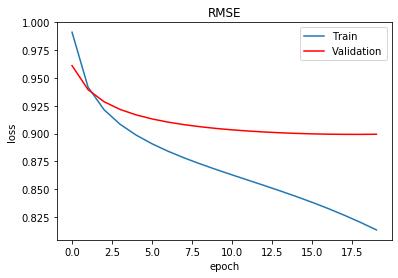

In [73]:
model = SVD(params, total_users, total_items)
model.fit(train_set, val_set, 1, plot=True)

In [74]:
model.test(test_set)

RMSE on test set: 0.9000087028404717


## Model basic bias on > 3 ratings per item and user, NOLF 50

Epoch: 0   RMSE: 1.2816425953502029  Val_RMSE: 1.2406658230785146
Epoch: 1   RMSE: 1.215456940998784  Val_RMSE: 1.1903024251800582
Epoch: 2   RMSE: 1.149333927079458  Val_RMSE: 1.1380630339521831
Epoch: 3   RMSE: 1.0810732998694672  Val_RMSE: 1.091939791915775
Epoch: 4   RMSE: 1.0223864179294353  Val_RMSE: 1.0539733250193384
Epoch: 5   RMSE: 0.9719632761829987  Val_RMSE: 1.0205001031180525
Epoch: 6   RMSE: 0.926583124857244  Val_RMSE: 0.9908805282863371
Epoch: 7   RMSE: 0.8859487431287936  Val_RMSE: 0.9650264615977123
Epoch: 8   RMSE: 0.8496454530161636  Val_RMSE: 0.9423571665352519
Epoch: 9   RMSE: 0.8167902038238551  Val_RMSE: 0.9221608727699828
Epoch: 10   RMSE: 0.7865697010824318  Val_RMSE: 0.9039019862473198
Epoch: 11   RMSE: 0.7584214701662612  Val_RMSE: 0.8872328669665153
Epoch: 12   RMSE: 0.731969713407502  Val_RMSE: 0.87191818707457
Epoch: 13   RMSE: 0.7069449959942637  Val_RMSE: 0.8577799343270004
Epoch: 14   RMSE: 0.6831402506970894  Val_RMSE: 0.8446731917497935
Epoch: 15   

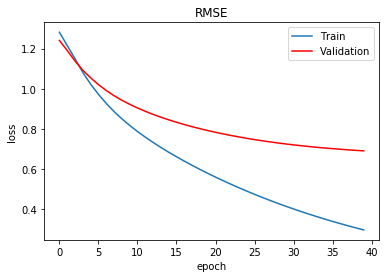

In [142]:
params['use_impl_fb'] = False
params['nolf'] = 50
model2 = SVD(params, total_users, total_items)
model2.fit(train_set, val_set, 1, plot=True)

In [143]:
model2.test(test_set)

RMSE on test set: 1.045499301421497


## Model basic bias on > 3 ratings per item and user

Epoch: 0   RMSE: 1.2817937351276467  Val_RMSE: 1.2460272046324068
Epoch: 1   RMSE: 1.2294991550513523  Val_RMSE: 1.2047853780833724
Epoch: 2   RMSE: 1.1813026968728284  Val_RMSE: 1.1631331521566382
Epoch: 3   RMSE: 1.128268613341925  Val_RMSE: 1.1212644309079391
Epoch: 4   RMSE: 1.0770674911676923  Val_RMSE: 1.0853626989262597
Epoch: 5   RMSE: 1.0333257618813638  Val_RMSE: 1.054175548711292
Epoch: 6   RMSE: 0.9946251036005469  Val_RMSE: 1.0262715304693484
Epoch: 7   RMSE: 0.9592060263789131  Val_RMSE: 1.0009931713141942
Epoch: 8   RMSE: 0.9268495183775911  Val_RMSE: 0.9783986383024866
Epoch: 9   RMSE: 0.8976745284329831  Val_RMSE: 0.9584057097061017
Epoch: 10   RMSE: 0.871345504071276  Val_RMSE: 0.9405984190840886
Epoch: 11   RMSE: 0.8472726707715788  Val_RMSE: 0.9245022651063308
Epoch: 12   RMSE: 0.8249575562863299  Val_RMSE: 0.9097706031062608
Epoch: 13   RMSE: 0.8040875062896613  Val_RMSE: 0.8961877794339881
Epoch: 14   RMSE: 0.7844712969324612  Val_RMSE: 0.8836120141395273
Epoch: 1

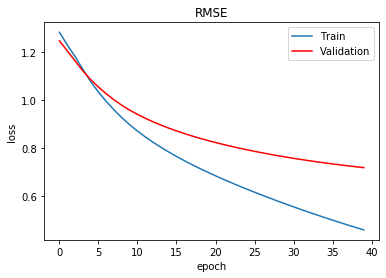

In [124]:
params['use_impl_fb'] = False
model2 = SVD(params, total_users, total_items)
model2.fit(train_set, val_set, 1, plot=True)

In [125]:
model2.test(test_set)

RMSE on test set: 1.046533936659222


## Model with impl_fb on > 3 ratings per item and user

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.2788803716444324  Val_RMSE: 1.2442447229245834
Epoch: 1   RMSE: 1.223206410608326  Val_RMSE: 1.203471197930423
Epoch: 2   RMSE: 1.1735274830389015  Val_RMSE: 1.165144204059552
Epoch: 3   RMSE: 1.1206507359902713  Val_RMSE: 1.1262370136945048
Epoch: 4   RMSE: 1.0661709248397233  Val_RMSE: 1.0885661284176056
Epoch: 5   RMSE: 1.0174968444412444  Val_RMSE: 1.054973469668485
Epoch: 6   RMSE: 0.9755827790457048  Val_RMSE: 1.026468226406956
Epoch: 7   RMSE: 0.9383543732938991  Val_RMSE: 1.001579623389147
Epoch: 8   RMSE: 0.9045356061774502  Val_RMSE: 0.9790809834462374
Epoch: 9   RMSE: 0.8733957127763815  Val_RMSE: 0.9584427347885147
Epoch: 10   RMSE: 0.8444829217104384  Val_RMSE: 0.9394943476250528
Epoch: 11   RMSE: 0.8175117721750365  Val_RMSE: 0.9221109812883124
Epoch: 12   RMSE: 0.7922461420859389  Val_RMSE: 0.9061129086262788
Epoch: 13   RMSE: 0.7684539985869975  Val_RMSE: 0.8913047568952395
Epoch: 14   RMSE: 0.7459154366

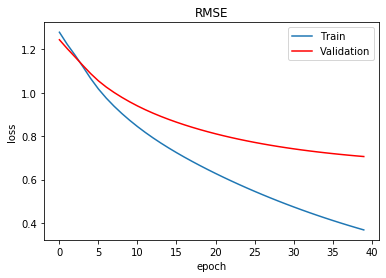

In [131]:
params['use_impl_fb'] = True
params['x_reg'] = 0.1
model3 = SVD(params, total_users, total_items)
model3.fit(train_set, val_set, 1, plot=True)

In [132]:
model3.test(test_set)

RMSE on test set: 1.0513793685008896


In [127]:
model3.test(test_set)

RMSE on test set: 1.060792813164172


# Store Results

In [ ]:
log_path = 'Results/'
res_name = 'res_#ratings_ui_above_3'

In [ ]:
model.store_results(log_path, res_name, user_thres, item_thres)

## Delete last results

In [ ]:
# pd.read_pickle(log_path + res_name)[1:].to_pickle(log_path + res_name)

# Cross Validation all algs data with #ratings/item & user > 3

In [13]:
from sklearn.model_selection import KFold
def cv(data, params, n_splits, res_name, model_res_name):
    kf = KFold(n_splits = n_splits, shuffle = True)
    full_data = data
    scores = []

    for i in range(n_splits):
        result = next(kf.split(full_data), None)
        train_set = full_data.iloc[result[0]]
        test_set = full_data.iloc[result[1]]
        model = SVD(params, total_users, total_items)
        model.fit(train_set, verbose = 1000, plot = False)
        
        model.test(test_set)
        model.store_results('', model_res_name, user_thres, item_thres)  

    df_cv_results = pd.read_pickle(model_res_name)[-5:]
    params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'use_color', 'use_weight_ver', 'ver_weight' 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
    avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
    final_dict = {**avg_rmse_dict, **params_dict}

    if not os.path.exists(res_name):
        cv_res = pd.DataFrame(columns=final_dict.keys())
        print('new results created')

    else:
        cv_res = pd.read_pickle(res_name)
        print('results added')

    cv_res = cv_res.append(final_dict, ignore_index=True)
    pd.to_pickle(cv_res, res_name)

## Bias Only

In [200]:
params

{'nolf': 15,
 'n_epochs': 40,
 'random_state': 1234,
 'alpha': 0.01,
 'alpha_b': 0.01,
 'alpha_cb': 0.001,
 'stop': False,
 'use_bias': True,
 'use_color': False,
 'use_impl_fb': False,
 'use_weight_ver': False,
 'bu_reg': 0.05,
 'bi_reg': 0.05,
 'pu_reg': 0.001,
 'qi_reg': 0.001,
 'x_reg': 0.001,
 'cb_reg': 0.01,
 'ver_weight': 0.5}

In [201]:
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_bias_only'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

Epoch: 0   RMSE: 1.27866934216042
RMSE on test set: 1.0583259918132621
results added
Epoch: 0   RMSE: 1.283223979321356
RMSE on test set: 1.0422455986364425
results added
Epoch: 0   RMSE: 1.285617609654094
RMSE on test set: 1.035702013338114
results added
Epoch: 0   RMSE: 1.2797633142753824
RMSE on test set: 1.054543165662046
results added
Epoch: 0   RMSE: 1.2806802295612514
RMSE on test set: 1.0816137617230432
results added
new results created


C:\Users\robin.opdam\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


## Weighted Verification and Bias

In [202]:
params

{'nolf': 15,
 'n_epochs': 40,
 'random_state': 1234,
 'alpha': 0.01,
 'alpha_b': 0.01,
 'alpha_cb': 0.001,
 'stop': False,
 'use_bias': True,
 'use_color': False,
 'use_impl_fb': False,
 'use_weight_ver': False,
 'bu_reg': 0.05,
 'bi_reg': 0.05,
 'pu_reg': 0.001,
 'qi_reg': 0.001,
 'x_reg': 0.001,
 'cb_reg': 0.01,
 'ver_weight': 0.5}

In [203]:
params['use_weight_ver'] = True
params['ver_weight'] = 0.7
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_ver_weight'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

Epoch: 0   RMSE: 1.2579622612241363
RMSE on test set: 1.0731069398883948
results added
Epoch: 0   RMSE: 1.2586830147984072
RMSE on test set: 1.060990229021861
results added
Epoch: 0   RMSE: 1.2602034375606015
RMSE on test set: 1.0515495721019124
results added
Epoch: 0   RMSE: 1.2576239293164444
RMSE on test set: 1.0873687613816412
results added
Epoch: 0   RMSE: 1.2578096245510555
RMSE on test set: 1.0639453855129504
results added
results added


C:\Users\robin.opdam\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


## Impl_fb with Bias

In [204]:
params

{'nolf': 15,
 'n_epochs': 40,
 'random_state': 1234,
 'alpha': 0.01,
 'alpha_b': 0.01,
 'alpha_cb': 0.001,
 'stop': False,
 'use_bias': True,
 'use_color': False,
 'use_impl_fb': False,
 'use_weight_ver': True,
 'bu_reg': 0.05,
 'bi_reg': 0.05,
 'pu_reg': 0.001,
 'qi_reg': 0.001,
 'x_reg': 0.001,
 'cb_reg': 0.01,
 'ver_weight': 0.7}

In [205]:
params['use_weight_ver'] = False
params['use_impl_fb'] = True
params['x_reg'] = 0.01
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_impl_fb'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.280958764452121
RMSE on test set: 1.0665184684151572
new results created
Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.2761796581293556
RMSE on test set: 1.0746881203806748
results added
Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.2831969207856746
RMSE on test set: 1.083573264025993
results added
Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.2747491758455864
RMSE on test set: 1.1007828749082365
results added
Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.2816360600594017
RMSE on test set: 1.083511750424759
results added
results added


C:\Users\robin.opdam\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


## Color attribute with Bias

In [14]:
params

{'nolf': 15,
 'n_epochs': 40,
 'random_state': 1234,
 'alpha': 0.01,
 'alpha_b': 0.01,
 'alpha_cb': 0.001,
 'stop': False,
 'use_bias': True,
 'use_color': True,
 'use_impl_fb': False,
 'use_weight_ver': False,
 'bu_reg': 0.05,
 'bi_reg': 0.05,
 'pu_reg': 0.001,
 'qi_reg': 0.001,
 'x_reg': 0.001,
 'cb_reg': 0.01,
 'ver_weight': 0.5}

In [15]:
params['use_impl_fb'] = False
params['use_color'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_color'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

Creating F and c, for incorporating color bias


KeyboardInterrupt: 

## Impl_fb with verification weights and Bias

In [ ]:
params

In [ ]:
params['use_impl_fb'] = True
params['use_color'] = False
params['use_weight_ver'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_ver_weight_impl_fb'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Color, impl_fb, weight_ver and bias

In [ ]:
params['use_impl_fb'] = True
params['use_color'] = True
params['use_weight_ver'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_bias_impl_fb_weight_color'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

## Results CV all algs

In [ ]:
df_cv_results = pd.read_pickle(res_name).sort_values('avg_rmse_test')
df_cv_results

# Cross Validation

In [49]:
res_name = 'cv_half_df_all_algs'
cv_res_name = 'cv_res_bias'
log_path = 'Results/'
n_splits = 5

In [50]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = n_splits, shuffle = True)
full_data = df_new_ids
scores = []

for i in range(n_splits):
    result = next(kf.split(full_data), None)
    train_set = full_data.iloc[result[0]]
    test_set = full_data.iloc[result[1]]
    model = SVD(params, total_users, total_items)
    model.fit(train_set, verbose = 1000, plot = False)

    model.test(test_set)
    model.store_results(log_path, cv_res_name, user_thres, item_thres)  

df_cv_results = pd.read_pickle(log_path + cv_res_name)[-5:]
params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'use_color', 'use_weight_ver', 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
final_dict = {**avg_rmse_dict, **params_dict}

if not os.path.exists(log_path + res_name):
    cv_res = pd.DataFrame(columns=final_dict.keys())
    print('new results created')

else:
    cv_res = pd.read_pickle(log_path + res_name)
    print('results added')

cv_res = cv_res.append(final_dict, ignore_index=True)
pd.to_pickle(cv_res, log_path + res_name)

Epoch: 0   RMSE: 1.4048207824488832  Val_RMSE: 1.386224944941462
RMSE on test set: 1.3363581816176826
new results created
Epoch: 0   RMSE: 1.4059400168910088  Val_RMSE: 1.386179620207678
RMSE on test set: 1.3320503726764636
results added
Epoch: 0   RMSE: 1.4041774267086913  Val_RMSE: 1.3866807517233175
RMSE on test set: 1.3393862376675862
results added
Epoch: 0   RMSE: 1.4045844384122934  Val_RMSE: 1.386262182638115
RMSE on test set: 1.3389733265619503
results added
Epoch: 0   RMSE: 1.4050537146410949  Val_RMSE: 1.3859760068010163
RMSE on test set: 1.33695948972803
results added
new results created


C:\Users\robin.opdam\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [51]:
df_cv_results = pd.read_pickle(log_path + res_name).sort_values('avg_rmse_test')
df_cv_results

,avg_rmse_test,nolf,n_epochs,random_state,alpha,alpha_b,use_bias,use_impl_fb,use_color,use_weight_verbu_reg,bi_reg,pu_reg,qi_reg,x_reg,u_thres,i_thres,train_size,test_size,train_rmse
0,1.336746,15,40,1234,0.004,0.004,True,False,False,NaN,0.05,0.001,0.001,0.01,1,1,0.8,0.2,"[1.4048207824488832, 1.3804407421418257, 1.361..."


# Read and View Results

## All models

In [ ]:
pd.read_pickle(log_path +'all_results_movie_lens')

### Old but gold

In [ ]:
pd.read_pickle('Results/df_comparison_impl_fb')

In [ ]:
df_results = pd.read_pickle('Results/' + 'df_results_svd')
df_results.sort_values('RMSE_test')

Note the RMSE in the first results should be higher (+1.1) due to a mistake in the calculation

In [ ]:
x = ['with Bias and Reg', 'with Bias', 'Plain']
y = [1.313160, 1.314319, 2.860927]

fig, ax = plt.subplots()
ind = np.arange(len(y))
width = 0.8
ax.bar(ind, y, width, color=['darkblue'])
ax.set_xticks(ind+width/500)
ax.set_xticklabels(x, minor=False)
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison')
for i, v in enumerate(y):
    ax.text(i -0.2, v + 0.02, str(v), fontweight='bold')
plt.show()

## Best model train RMSE

### Best from Comparison

In [ ]:
best = df_results_b.iloc[6]
model.plot_rmse(best['train_rmse'])

### Best of All Models

In [ ]:
best = df_results_all
model.plot_rmse(best['train_rmse'])

# Appendix

## Data Split (Pandas)

In [ ]:
# from scipy.linalg import sqrtm

# X_train, X_test = train_test_split(df, test_size=0.10, shuffle=True, random_state=1234)
# X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=1234)

# def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
#     """
#         :param data:      Array-like, 2D, nx3
#         :param formatizer:pass the formatizer
#         :return:          utility matrix (n x m), n=users, m=items
#     """
        
#     itemField = formatizer['item']
#     userField = formatizer['user']
#     valueField = formatizer['value']
    
#     userList = data.iloc[:,userField].tolist()
#     itemList = data.iloc[:,itemField].tolist()
#     valueList = data.iloc[:,valueField].tolist()
    
#     users = list(set(data.iloc[:,userField]))
#     items = list(set(data.iloc[:,itemField]))
    
#     users_index = {users[i]: i for i in range(len(users))}
#     pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    
#     for i in range(0,len(data)):
#         item = itemList[i]
#         user = userList[i]
#         value = valueList[i]
        
#     pd_dict[item][users_index[user]] = value
#     X = pd.DataFrame(pd_dict)
#     X.index = users
        
#     itemcols = list(X.columns)
#     items_index = {itemcols[i]: i for i in range(len(itemcols))}
#     # users_index gives us a mapping of user_id to index of user
#     # items_index provides the same for items
#     return X, users_index, items_index

# X, users_index, items_index = create_utility_matrix(X_train)

hide_toggle()

## Create user item matrix

In [ ]:
# n_users = df.user.unique().shape[0]
# n_items = df.item.unique().shape[0]

# ratings_train = np.zeros((n_users, n_items))
# for row in X_train.itertuples():
#         ratings_train[row[5], row[4]] = row[3]

# pd.DataFrame(ratings_train).head()
# # sparse.csr_matrix((X_train['rating']),shape(n_users, n_items))
hide_toggle()

## Different SGD coding

In [ ]:
# user_item_combos = 0
# for epoch in range(n_epochs):
#     for u in range(ratings_train.shape[0]): #users
#         for i in range(ratings_train.shape[1]): #items
#             r_ui = ratings_train[u,i]
            
#             if  r_ui != 0:
#                 user_item_combos += 1
#                 error = r_ui - np.dot(p[u], q[i])
                
#                 p[u] += alpha *(error * q[i])
#                 q[i] += alpha * (error * p[u])
                
#                 total_error += np.square(error)
# #         print(total_error)
#     rmse = math.sqrt(total_error)
#     print('epoch: ', epoch)#, '  rmse: ', rmse)
#     print(user_item_combos, X_train['rating'].shape[0])
hide_toggle()

## With regularization

In [ ]:
# b_user[u] += alpha_b * (error - bu_reg * b_user[u])
# b_item[i] += alpha_b * (error - bi_reg * b_item[i])
            
# p[u] += alpha * (error * q[i] - pu_reg * p[u])
# q[i] += alpha * (error * p[u] - qi_reg * q[i])
hide_toggle()

## Colors binary split

In [ ]:
# plt.rcParams['figure.figsize'] = [8,6]
# pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]/len(df)).sum()
# non_pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/len(df)).sum()

# bars = plt.bar(['pop_col', 'non_pop_col'], [pop_col, non_pop_col])
# plt.text(bars[0].get_x() + 0.13, pop_col + -0.05, pop_col, color="white", fontweight = 'bold')
# plt.text(bars[1].get_x() + 0.13, non_pop_col + -0.05, non_pop_col, color="white", fontweight = 'bold')
# plt.title('Binary split between 35 most populair colors and non populair colors')
# plt.show()

In [ ]:
# pop_colors = df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35] 

# def pop_color(x):
#     x = x['Color:']
#     if x in pop_colors:
#         return 1
#     elif x not in pop_colors:
#         return 0
#     else:
#         return False

# temp_df = pd.DataFrame()
# temp_df['bin_pop_col'] = df.apply(pop_color, axis=1, result_type='expand')
# df = df.merge(temp_df, left_index=True, right_index=True)